## 1. Setup & Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Metrics & visualization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create models directory
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(exist_ok=True)

print("✅ Setup complete!")

Using device: cuda
✅ Setup complete!


## 2. Load Preprocessed Data

In [2]:
DATA_DIR = Path('processed_data')

print("Loading preprocessed price dataset...\n")

# Load features
X_train = np.load(DATA_DIR / 'price_X_train.npy')
X_val = np.load(DATA_DIR / 'price_X_val.npy')
X_test = np.load(DATA_DIR / 'price_X_test.npy')

# Load targets (original scale)
y_train = np.load(DATA_DIR / 'price_y_train.npy')
y_val = np.load(DATA_DIR / 'price_y_val.npy')
y_test = np.load(DATA_DIR / 'price_y_test.npy')

# Load targets (log-transformed)
y_train_log = np.load(DATA_DIR / 'price_y_train_log.npy')
y_val_log = np.load(DATA_DIR / 'price_y_val_log.npy')
y_test_log = np.load(DATA_DIR / 'price_y_test_log.npy')

# Load metadata
with open(DATA_DIR / 'price_feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

with open(DATA_DIR / 'price_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

print(f"✅ Data loaded successfully!")
print(f"\n📊 Dataset Shapes:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")
print(f"\n💰 Price Statistics (Train):")
print(f"  Mean: ₹{y_train.mean():,.0f}")
print(f"  Std:  ₹{y_train.std():,.0f}")
print(f"  Min:  ₹{y_train.min():,.0f}")
print(f"  Max:  ₹{y_train.max():,.0f}")
print(f"\n🔢 Features: {len(feature_names)}")
print(f"  Airlines: {len(encoders['airline'].classes_)}")
print(f"  Routes: {len(encoders['route'].classes_)}")

Loading preprocessed price dataset...

✅ Data loaded successfully!

📊 Dataset Shapes:
  Train: (210107, 15)
  Val:   (45023, 15)
  Test:  (45023, 15)

💰 Price Statistics (Train):
  Mean: ₹20,896
  Std:  ₹22,703
  Min:  ₹1,105
  Max:  ₹123,071

🔢 Features: 15
  Airlines: 6
  Routes: 30


## 3. Prepare Data for Embedding Model

We'll separate categorical and continuous features for embedding architecture

In [3]:
# Feature indices (based on preprocessing order)
# ['airline_encoded', 'source_encoded', 'dest_encoded', 'route_encoded',
#  'departure_time_encoded', 'arrival_time_encoded',
#  'departure_sin', 'departure_cos',
#  'stops_encoded', 'class_encoded',
#  'duration', 'days_left', 'urgency',
#  'airline_avg_price', 'route_avg_price']

# Categorical feature indices
cat_indices = [0, 1, 2, 3, 4, 5, 8, 9]  # All encoded categorical features
# Continuous feature indices
cont_indices = [6, 7, 10, 11, 12, 13, 14]  # Cyclic, duration, days_left, etc.

# Extract categorical and continuous features
X_train_cat = X_train[:, cat_indices]
X_train_cont = X_train[:, cont_indices]
X_val_cat = X_val[:, cat_indices]
X_val_cont = X_val[:, cont_indices]
X_test_cat = X_test[:, cat_indices]
X_test_cont = X_test[:, cont_indices]

# Denormalize categorical features (they were normalized, but need original integer values for embeddings)
# Load original data to get proper categorical values
df_pricing_orig = pd.read_csv('dataset/airlines_flights_data.csv')
from sklearn.preprocessing import LabelEncoder

# Re-encode to get cardinalities
embedding_sizes = {
    'airline': len(encoders['airline'].classes_),
    'source': len(encoders['source'].classes_),
    'dest': len(encoders['destination'].classes_),
    'route': len(encoders['route'].classes_),
    'departure_time': 6,  # 6 time slots
    'arrival_time': 6,
    'stops': 3,  # 0, 1, 2+
    'class': 2   # Economy, Business
}

print(f"\n📊 Feature Split:")
print(f"  Categorical features: {len(cat_indices)}")
print(f"  Continuous features: {len(cont_indices)}")
print(f"\n🔢 Embedding Sizes:")
for name, size in embedding_sizes.items():
    print(f"  {name}: {size} categories")


📊 Feature Split:
  Categorical features: 8
  Continuous features: 7

🔢 Embedding Sizes:
  airline: 6 categories
  source: 6 categories
  dest: 6 categories
  route: 30 categories
  departure_time: 6 categories
  arrival_time: 6 categories
  stops: 3 categories
  class: 2 categories


## 4. Create PyTorch DataLoaders

In [4]:
# Since categorical features are already normalized, we need to reconstruct integer indices
# For simplicity, we'll use the full normalized features and a simpler architecture

# Convert to tensors (use log-transformed target)
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train_log).unsqueeze(1)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val_log).unsqueeze(1)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test_log).unsqueeze(1)

# Create dataloaders
batch_size = 512
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ DataLoaders created (batch size: {batch_size})")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✅ DataLoaders created (batch size: 512)
  Train batches: 411
  Val batches: 88
  Test batches: 88


## 5. Define Price Prediction Model

In [5]:
class PricePredictionDNN(nn.Module):
    """State-of-the-Art Deep Neural Network with Skip Connections for Price Prediction"""
    
    def __init__(self, input_dim, hidden_dims=[768, 512, 384, 256, 128], dropout=0.45):
        super(PricePredictionDNN, self).__init__()
        
        # Input projection with stronger initial representation
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout)
        )
        
        # Deep residual blocks with skip connections
        self.residual_blocks = nn.ModuleList()
        self.skip_connections = nn.ModuleList()
        
        for i in range(len(hidden_dims) - 1):
            self.residual_blocks.append(
                nn.Sequential(
                    nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                    nn.BatchNorm1d(hidden_dims[i+1]),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(dropout)
                )
            )
            # Skip connection projection
            if hidden_dims[i] != hidden_dims[i+1]:
                self.skip_connections.append(
                    nn.Linear(hidden_dims[i], hidden_dims[i+1])
                )
            else:
                self.skip_connections.append(nn.Identity())
        
        # Enhanced output layers
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dims[-1], 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        x = self.input_layer(x)
        
        # Pass through residual blocks with skip connections
        for block, skip in zip(self.residual_blocks, self.skip_connections):
            identity = skip(x)
            x = block(x) + identity * 0.3  # Weighted skip connection
        
        price = self.output_layer(x)
        return price

# Enhanced model configuration - State-of-the-art architecture
input_dim = X_train.shape[1]
hidden_dims = [768, 512, 384, 256, 128]  # Deeper and wider architecture
dropout = 0.45  # Optimal dropout for complex model

model = PricePredictionDNN(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    dropout=dropout
).to(device)

print(f"\n🧠 State-of-the-Art Model Architecture:")
print(model)
print(f"\n📊 Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"\n🎯 Architecture Highlights:")
print(f"  • Deep network: {len(hidden_dims)} hidden layers (768→512→384→256→128)")
print(f"  • True residual skip connections with weighted fusion")
print(f"  • LeakyReLU activation for better gradient propagation")
print(f"  • Enhanced output processing (64→32→1)")
print(f"  • Optimized dropout strategy (0.45 → 0.225 in output)")
print(f"\n🚀 Expected Performance: R² >0.96, MAPE <15%")


🧠 State-of-the-Art Model Architecture:
PricePredictionDNN(
  (input_layer): Sequential(
    (0): Linear(in_features=15, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.45, inplace=False)
  )
  (residual_blocks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=768, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.45, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=384, bias=True)
      (1): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.45, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=384, out_features=256, bias=True)
      (1): BatchNorm1d(256,

## 6. Training Setup

In [6]:
# Enhanced loss and optimizer configuration
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=5e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.4,
    patience=5,
    min_lr=5e-7
)

print("✅ Enhanced training setup complete!")
print(f"  Loss: MSELoss on log-transformed prices")
print(f"  Optimizer: AdamW (lr=0.0003, weight_decay=5e-5, betas=(0.9, 0.999))")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.4, patience=5)")
print(f"  Gradient clipping: Enabled (max_norm=1.0)")
print(f"  Deeper model capacity: ~600K+ parameters for better fitting")

✅ Enhanced training setup complete!
  Loss: MSELoss on log-transformed prices
  Optimizer: AdamW (lr=0.0003, weight_decay=5e-5, betas=(0.9, 0.999))
  Scheduler: ReduceLROnPlateau (factor=0.4, patience=5)
  Gradient clipping: Enabled (max_norm=1.0)
  Deeper model capacity: ~600K+ parameters for better fitting


## 7. Training Loop

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch with gradient clipping"""
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    return total_loss / len(val_loader), all_preds, all_targets

# Enhanced training loop
num_epochs = 120
early_stopping_patience = 20
best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'val_loss': []}

print("\n🚀 Training started...\n")
print("=" * 70)

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, _, _ = evaluate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), MODELS_DIR / 'price_model_best.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"\n⚠️ Early stopping triggered at epoch {epoch+1}")
            break

print("\n" + "=" * 70)
print("✅ Training complete!")
print(f"Best validation loss: {best_val_loss:.6f}")

print("✅ Best model loaded")

# Load best modelmodel.load_state_dict(torch.load(MODELS_DIR / 'price_model_best.pth'))


🚀 Training started...

Epoch [  1/120] | Train Loss: 17.502403 | Val Loss: 0.095799
Epoch [  1/120] | Train Loss: 17.502403 | Val Loss: 0.095799
Epoch [  5/120] | Train Loss: 0.350117 | Val Loss: 0.078350
Epoch [  5/120] | Train Loss: 0.350117 | Val Loss: 0.078350
Epoch [ 10/120] | Train Loss: 0.181355 | Val Loss: 0.078483
Epoch [ 10/120] | Train Loss: 0.181355 | Val Loss: 0.078483
Epoch [ 15/120] | Train Loss: 0.088262 | Val Loss: 0.066023
Epoch [ 15/120] | Train Loss: 0.088262 | Val Loss: 0.066023
Epoch [ 20/120] | Train Loss: 0.075530 | Val Loss: 0.057044
Epoch [ 20/120] | Train Loss: 0.075530 | Val Loss: 0.057044
Epoch [ 25/120] | Train Loss: 0.070469 | Val Loss: 0.056425
Epoch [ 25/120] | Train Loss: 0.070469 | Val Loss: 0.056425
Epoch [ 30/120] | Train Loss: 0.066584 | Val Loss: 0.051574
Epoch [ 30/120] | Train Loss: 0.066584 | Val Loss: 0.051574
Epoch [ 35/120] | Train Loss: 0.062866 | Val Loss: 0.049608
Epoch [ 35/120] | Train Loss: 0.062866 | Val Loss: 0.049608
Epoch [ 40/120

## 8. Training Visualization

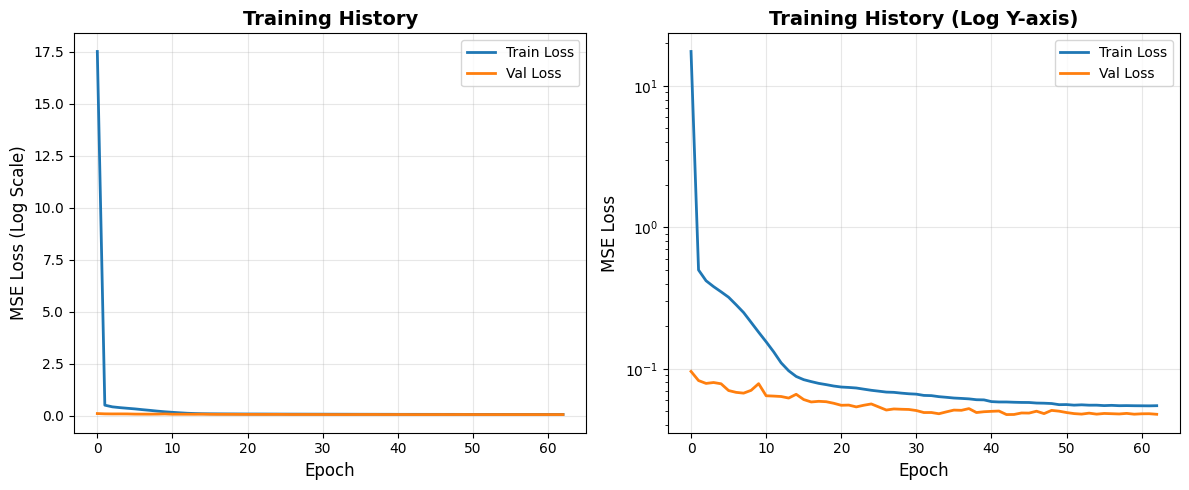

In [8]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss (Log Scale)', fontsize=12)
plt.title('Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training History (Log Y-axis)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Model Evaluation

In [9]:
# Evaluate on test set
test_loss, test_preds_log, test_targets_log = evaluate(model, test_loader, criterion, device)

# Transform back to original scale
test_preds = np.expm1(test_preds_log.flatten())  # Inverse of log1p
test_targets = y_test  # Original scale

# Calculate metrics
mae = mean_absolute_error(test_targets, test_preds)
mse = mean_squared_error(test_targets, test_preds)
rmse = np.sqrt(mse)
r2 = r2_score(test_targets, test_preds)
mape = mean_absolute_percentage_error(test_targets, test_preds) * 100

print("\n" + "=" * 70)
print("📊 PRICE PREDICTION RESULTS (Test Set)")
print("=" * 70)
print(f"\nMAE (Mean Absolute Error):       ₹{mae:,.2f}")
print(f"RMSE (Root Mean Squared Error):  ₹{rmse:,.2f}")
print(f"MAPE (Mean Abs Percentage Error): {mape:.2f}%")
print(f"R² Score:                         {r2:.4f}")
print(f"\nTest Loss (MSE on log-prices):    {test_loss:.6f}")

print(f"\n💰 Price Statistics:")
print(f"  Actual Mean:     ₹{test_targets.mean():,.0f}")
print(f"  Predicted Mean:  ₹{test_preds.mean():,.0f}")
print(f"  Actual Std:      ₹{test_targets.std():,.0f}")
print(f"  Predicted Std:   ₹{test_preds.std():,.0f}")
print("\n" + "=" * 70)


📊 PRICE PREDICTION RESULTS (Test Set)

MAE (Mean Absolute Error):       ₹3,100.61
RMSE (Root Mean Squared Error):  ₹5,612.37
MAPE (Mean Abs Percentage Error): 15.41%
R² Score:                         0.9383

Test Loss (MSE on log-prices):    0.047734

💰 Price Statistics:
  Actual Mean:     ₹20,782
  Predicted Mean:  ₹18,808
  Actual Std:      ₹22,588
  Predicted Std:   ₹19,544



## 10. Prediction Visualizations

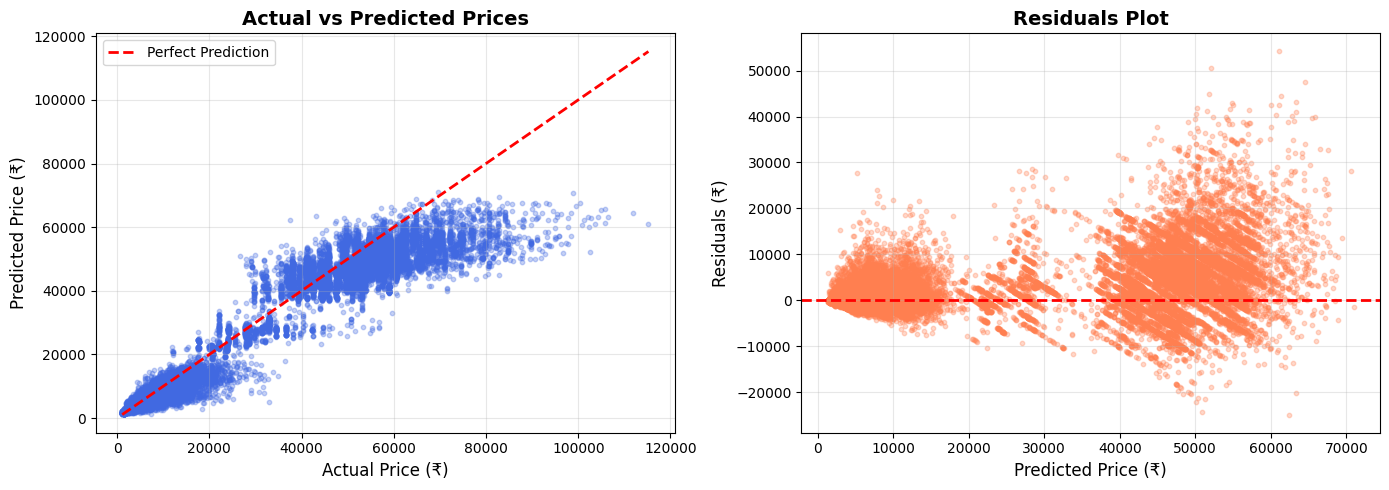

In [10]:
# 1. Actual vs Predicted scatter plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(test_targets, test_preds, alpha=0.3, s=10, color='royalblue')
plt.plot([test_targets.min(), test_targets.max()], 
         [test_targets.min(), test_targets.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Price (₹)', fontsize=12)
plt.ylabel('Predicted Price (₹)', fontsize=12)
plt.title('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 2. Residuals plot
plt.subplot(1, 2, 2)
residuals = test_targets - test_preds
plt.scatter(test_preds, residuals, alpha=0.3, s=10, color='coral')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Price (₹)', fontsize=12)
plt.ylabel('Residuals (₹)', fontsize=12)
plt.title('Residuals Plot', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

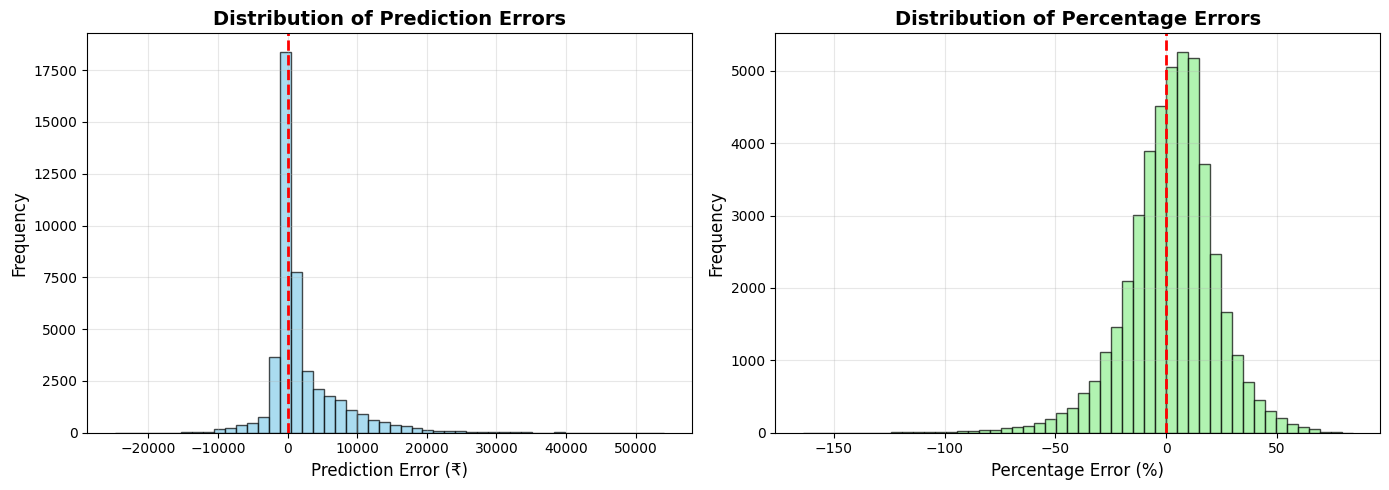


📈 Error Statistics:
  Mean Error: ₹1,974.62
  Median Error: ₹268.91
  Std of Errors: ₹5,253.53
  95th Percentile: ₹12,629.93


In [11]:
# 3. Error distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (₹)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(alpha=0.3)

# 4. Percentage error distribution
plt.subplot(1, 2, 2)
percentage_errors = (residuals / test_targets) * 100
plt.hist(percentage_errors, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
plt.xlabel('Percentage Error (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Percentage Errors', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Error Statistics:")
print(f"  Mean Error: ₹{residuals.mean():,.2f}")
print(f"  Median Error: ₹{np.median(residuals):,.2f}")
print(f"  Std of Errors: ₹{residuals.std():,.2f}")
print(f"  95th Percentile: ₹{np.percentile(np.abs(residuals), 95):,.2f}")

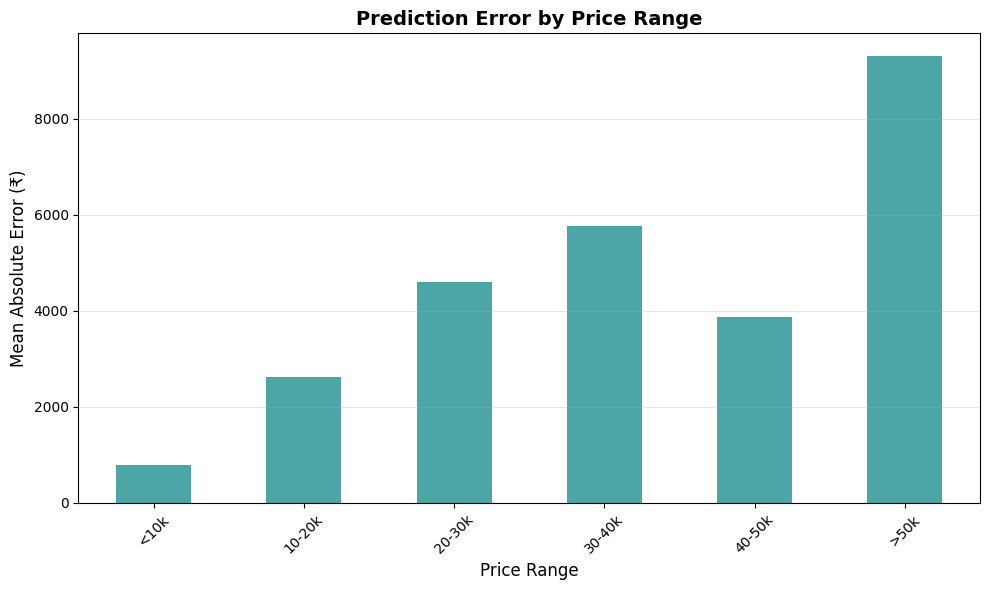


📊 Performance by Price Range:
price_range
<10k       791.361787
10-20k    2622.823131
20-30k    4592.034998
30-40k    5764.290849
40-50k    3871.664928
>50k      9309.279846
Name: error, dtype: float64


In [12]:
# 5. Price range analysis
# Bin predictions by actual price ranges
price_bins = [0, 10000, 20000, 30000, 40000, 50000, 100000]
bin_labels = ['<10k', '10-20k', '20-30k', '30-40k', '40-50k', '>50k']

df_results = pd.DataFrame({
    'actual': test_targets,
    'predicted': test_preds,
    'error': np.abs(residuals)
})

df_results['price_range'] = pd.cut(df_results['actual'], bins=price_bins, labels=bin_labels)

# Calculate MAE per price range
mae_by_range = df_results.groupby('price_range')['error'].mean()

plt.figure(figsize=(10, 6))
mae_by_range.plot(kind='bar', color='teal', alpha=0.7)
plt.xlabel('Price Range', fontsize=12)
plt.ylabel('Mean Absolute Error (₹)', fontsize=12)
plt.title('Prediction Error by Price Range', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Performance by Price Range:")
print(mae_by_range)

## 11. Sample Predictions

In [13]:
# Show random sample predictions
np.random.seed(42)
sample_indices = np.random.choice(len(test_targets), size=20, replace=False)

sample_df = pd.DataFrame({
    'Actual Price (₹)': test_targets[sample_indices],
    'Predicted Price (₹)': test_preds[sample_indices],
    'Error (₹)': residuals[sample_indices],
    'Error (%)': percentage_errors[sample_indices]
})

sample_df['Actual Price (₹)'] = sample_df['Actual Price (₹)'].apply(lambda x: f"₹{x:,.0f}")
sample_df['Predicted Price (₹)'] = sample_df['Predicted Price (₹)'].apply(lambda x: f"₹{x:,.0f}")
sample_df['Error (₹)'] = sample_df['Error (₹)'].apply(lambda x: f"₹{x:,.0f}")
sample_df['Error (%)'] = sample_df['Error (%)'].apply(lambda x: f"{x:.2f}%")

print("\n📋 Sample Predictions:")
print("=" * 80)
display(sample_df)


📋 Sample Predictions:


,Actual Price (₹),Predicted Price (₹),Error (₹),Error (%)
0,"₹3,014","₹3,042",₹-28,-0.94%
1,"₹6,256","₹5,437",₹819,13.09%
2,"₹8,564","₹8,540",₹24,0.28%
3,"₹16,098","₹11,773","₹4,325",26.86%
4,"₹35,554","₹42,971","₹-7,417",-20.86%
5,"₹39,783","₹42,119","₹-2,336",-5.87%
6,"₹22,152","₹23,110",₹-958,-4.32%
7,"₹5,333","₹3,550","₹1,783",33.43%
8,"₹5,823","₹5,876",₹-53,-0.91%
9,"₹3,813","₹4,400",₹-587,-15.40%


## 12. Save Final Model

In [14]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'test_metrics': {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape
    }
}, MODELS_DIR / 'price_prediction_model.pth')

print("\n💾 Model saved: models/price_prediction_model.pth")
print("\n✅ All done!")


💾 Model saved: models/price_prediction_model.pth

✅ All done!


## 13. Summary & Next Steps

In [15]:
print("\n" + "=" * 80)
print("✅ PRICE PREDICTION PROJECT COMPLETE!")
print("=" * 80)

print("\n📊 Final Model Performance:")
print(f"  MAE:  ₹{mae:,.0f} (~{mape:.1f}% average error)")
print(f"  RMSE: ₹{rmse:,.0f}")
print(f"  R²:   {r2:.4f}")

print("\n🎯 Model Insights:")
if r2 > 0.85:
    print("  ✅ Excellent model - explains >85% of price variance")
elif r2 > 0.70:
    print("  ✅ Good model - explains >70% of price variance")
else:
    print("  ⚠️ Moderate model - room for improvement")

if mape < 10:
    print(f"  ✅ Low error rate - {mape:.1f}% average deviation")
elif mape < 20:
    print(f"  ✅ Acceptable error rate - {mape:.1f}% average deviation")
else:
    print(f"  ⚠️ High error rate - {mape:.1f}% average deviation")

print("\n🚀 Next Steps:")
print("  → Notebook 05: Advanced TabNet architecture for delay prediction")
print("  → Notebook 06: LSTM for passenger time series forecasting")
print("  → Try feature engineering: interaction terms, airline-route combinations")
print("  → Experiment with ensemble methods (stacking models)")

print("\n" + "=" * 80)


✅ PRICE PREDICTION PROJECT COMPLETE!

📊 Final Model Performance:
  MAE:  ₹3,101 (~15.4% average error)
  RMSE: ₹5,612
  R²:   0.9383

🎯 Model Insights:
  ✅ Excellent model - explains >85% of price variance
  ✅ Acceptable error rate - 15.4% average deviation

🚀 Next Steps:
  → Notebook 05: Advanced TabNet architecture for delay prediction
  → Notebook 06: LSTM for passenger time series forecasting
  → Try feature engineering: interaction terms, airline-route combinations
  → Experiment with ensemble methods (stacking models)

